In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os

# --- CONFIG ---
SCALE = 1024.0
DATA_DIR = "../data/tests/test1"
WEIGHTS_DIR = "../data/model_csv/model_1"
PAD_CFG = ((2, 3), (2, 3)) # ((Top, Bot), (Left, Right))

os.makedirs(DATA_DIR, exist_ok=True)

# --- 1. HARDWARE EMULATION FUNCTIONS (PYTORCH) ---
def to_q6_10_numpy(tensor):
    """Convert Tensor to Numpy Fixed Point Q6.10 (Clamped)"""
    # Detach, move to cpu, numpy
    arr = tensor.detach().cpu().numpy()
    return np.clip(np.round(arr * SCALE), -32768, 32767).astype(int)

def rtl_leaky_relu(x):
    """Match RTL Leaky ReLU approx (x * 13/64)"""
    return F.leaky_relu(x, negative_slope=13.0/64.0)

def rtl_conv2d_stride2(x, w, b):
    """
    RTL Logic: Conv Valid -> Stride 2 Output
    PyTorch Conv2d with stride=2 matches this exactly for valid padding.
    """
    return F.conv2d(x, w, bias=b, stride=2, padding=0)

def rtl_trans_conv_padded(x, w, b, pad_cfg):
    """
    Logic V3: Zero Insertion -> Asymmetric Padding -> Valid Conv
    """
    # x shape: (Batch, Channel, H, W)
    B, C, H, W = x.shape
    
    # 1. Upsample (Insert Zeros) - Match RTL upsample_layer_2d.v
    # Create canvas 2x size
    up = torch.zeros((B, C, H*2, W*2), dtype=x.dtype, device=x.device)
    # Fill pixels at stride 2 (0, 2, 4...)
    up[:, :, 0::2, 0::2] = x
    
    # 2. Padding - Match RTL zero_pad_layer.v
    # pad_cfg is ((Top, Bot), (Left, Right))
    # PyTorch F.pad expects tuple: (Left, Right, Top, Bot) !!
    top, bot = pad_cfg[0]
    left, right = pad_cfg[1]
    
    padded = F.pad(up, (left, right, top, bot), mode='constant', value=0)
    
    # 3. Conv Valid
    # Kernel di RTL 4x4, Conv valid biasa
    return F.conv2d(padded, w, bias=b, padding=0)

# --- 2. CLASS GENERATOR V3 (PYTORCH VERSION) ---
class GeneratorV3_Torch(torch.nn.Module):
    def __init__(self, w_dir):
        super().__init__()
        self.weights = {}
        self.load_all_weights(w_dir)
        
    def load_layer(self, name, k_size):
        w_path = os.path.join(WEIGHTS_DIR, f"{name}_weight.csv")
        b_path = os.path.join(WEIGHTS_DIR, f"{name}_bias.csv")
        
        # Load Weights (Assuming single channel processing like Scipy script)
        # Shape: (Out_Ch=1, In_Ch=1, K, K)
        if not os.path.exists(w_path):
            print(f"⚠️ Warning: Missing {w_path}, using random.")
            w_np = np.random.randn(1, 1, k_size, k_size)
            b_np = np.array([0.0])
        else:
            w_flat = pd.read_csv(w_path, header=None).values.flatten()
            b_val  = pd.read_csv(b_path, header=None).values.flatten()[0]
            w_np = w_flat.reshape(1, 1, k_size, k_size)
            b_np = np.array([b_val])

        # Register as parameters/buffers (non-trainable for simulation)
        self.weights[f"{name}_w"] = torch.tensor(w_np, dtype=torch.float32)
        self.weights[f"{name}_b"] = torch.tensor(b_np, dtype=torch.float32)

    def load_all_weights(self, w_dir):
        self.load_layer("enc1", 3)
        self.load_layer("enc2", 4)
        self.load_layer("enc3", 4)
        self.load_layer("dec1", 4)
        self.load_layer("dec2", 4)
        self.load_layer("out",  3)

    def forward(self, x):
        # x input shape must be (Batch, 1, H, W)
        res = {}
        w = self.weights
        
        # ENC 1 (32 -> 30) : Conv 3x3 Valid
        out = F.conv2d(x, w["enc1_w"], bias=w["enc1_b"], padding=0)
        out = rtl_leaky_relu(out)
        res['enc1'] = out
        
        # ENC 2 (30 -> 14) : Conv 4x4 Stride 2
        out = rtl_conv2d_stride2(out, w["enc2_w"], w["enc2_b"])
        out = rtl_leaky_relu(out)
        res['enc2'] = out
        
        # ENC 3 (14 -> 6) : Conv 4x4 Stride 2
        out = rtl_conv2d_stride2(out, w["enc3_w"], w["enc3_b"])
        out = rtl_leaky_relu(out)
        res['enc3'] = out
        
        # DEC 1 (6 -> 14) : Trans Conv Padded (Upsample -> Pad -> Valid)
        out = rtl_trans_conv_padded(out, w["dec1_w"], w["dec1_b"], PAD_CFG)
        out = rtl_leaky_relu(out)
        res['dec1'] = out
        
        # DEC 2 (14 -> 30) : Trans Conv Padded
        out = rtl_trans_conv_padded(out, w["dec2_w"], w["dec2_b"], PAD_CFG)
        out = rtl_leaky_relu(out)
        res['dec2'] = out
        
        # OUT (30 -> 28) : Conv 3x3 Valid
        out = F.conv2d(out, w["out_w"], bias=w["out_b"], padding=0)
        out = torch.tanh(out)
        res['out'] = out
        
        return res

# --- 3. GENERATE INPUT (MOVING BALL) ---
def create_ball(x, y, radius=6, size=32):
    yy, xx = np.meshgrid(np.arange(size), np.arange(size))
    ball = np.where(np.sqrt((xx - x)**2 + (yy - y)**2) <= radius, 1.0, -1.0)
    return ball.astype(np.float32)

# 2 Frames
img1 = create_ball(10, 16)
img2 = create_ball(22, 16)
frames_np = [img1, img2]

# --- 4. RUN MODEL & SAVE ---
gen = GeneratorV3_Torch(WEIGHTS_DIR)
gen.eval() # Set eval mode (standard practice)

input_stream = []
ref_layers = {k: [] for k in ['enc1', 'enc2', 'enc3', 'dec1', 'dec2', 'out']}

print("--- Running PyTorch Reference ---")
with torch.no_grad(): # Disable gradient calc for speed
    for i, frame_np in enumerate(frames_np):
        print(f"Processing Frame {i}...")
        
        # Convert to Tensor (Batch=1, Ch=1, H, W)
        frame_tensor = torch.tensor(frame_np).unsqueeze(0).unsqueeze(0)
        
        # 1. Simpan Input Stream (Q6.10) - from numpy source
        frame_fixed = to_q6_10_numpy(frame_tensor.squeeze())
        input_stream.extend(frame_fixed.flatten())
        
        # 2. Forward Pass
        results = gen(frame_tensor)
        
        # 3. Simpan Intermediate Layers
        for key in ref_layers:
            # Output tensor shape is (1, 1, H, W) -> Squeeze to (H, W)
            data_fixed = to_q6_10_numpy(results[key].squeeze())
            ref_layers[key].extend(data_fixed.flatten())
            
            # Print shape check for first frame
            if i == 0:
                print(f"  > {key} shape: {data_fixed.shape}")

# --- 5. WRITE CSV FILES ---
np.savetxt(f"{DATA_DIR}/test1_input.csv", np.array(input_stream), fmt='%d')
print(f"Saved Input: {len(input_stream)} values")

for key, data in ref_layers.items():
    arr = np.array(data)
    np.savetxt(f"{DATA_DIR}/ref_{key}.csv", arr, fmt='%d')
    print(f"Saved ref_{key}.csv: {len(arr)} values")

print("Done.")

--- Running PyTorch Reference ---
Processing Frame 0...
  > enc1 shape: (30, 30)
  > enc2 shape: (14, 14)
  > enc3 shape: (6, 6)
  > dec1 shape: (14, 14)
  > dec2 shape: (30, 30)
  > out shape: (28, 28)
Processing Frame 1...
Saved Input: 2048 values
Saved ref_enc1.csv: 1800 values
Saved ref_enc2.csv: 392 values
Saved ref_enc3.csv: 72 values
Saved ref_dec1.csv: 392 values
Saved ref_dec2.csv: 1800 values
Saved ref_out.csv: 1568 values
Done.


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import os

def generate_and_save_balls(output_dir):
    """
    Generate 2 frame bola bergerak (x=10 dan x=22) dan simpan sebagai PNG.
    """
    # Pastikan folder tujuan ada
    os.makedirs(output_dir, exist_ok=True)
    
    def create_ball(x, y, radius=5, size=64):
        yy, xx = np.meshgrid(np.arange(size), np.arange(size))
        # Logic: 1.0 di dalam radius (Putih), -1.0 di luar (Hitam)
        ball = np.where(np.sqrt((xx - x)**2 + (yy - y)**2) <= radius, 1.0, -1.0)
        return ball.astype(np.float32)

    # 1. Generate Data (Sama persis dengan script PyTorch)
    img1 = create_ball(20, 32) # Frame 1
    img2 = create_ball(40, 32) # Frame 2
    frames = [(img1, "imgA.png"), (img2, "imgB.png")]

    print(f"Generating images in: {output_dir}")

    for img_data, filename in frames:
        path = os.path.join(output_dir, filename)
        
        # 2. Visualisasi / Save
        # Karena range data -1.0 s/d 1.0, kita bisa langsung save pakai cmap='gray'.
        # vmin=-1, vmax=1 memastikan -1 jadi Hitam pekat, 1 jadi Putih pekat.
        plt.imsave(path, img_data, cmap='gray', vmin=-1.0, vmax=1.0)
        print(f"✅ Saved: {path}")

# --- PENGGUNAAN ---
OUTPUT_PATH = "../data/tests/test2/00_raw/"  # Ganti path sesuai kebutuhan
generate_and_save_balls(OUTPUT_PATH)

Generating images in: ../data/tests/test2/00_raw/
✅ Saved: ../data/tests/test2/00_raw/imgA.png
✅ Saved: ../data/tests/test2/00_raw/imgB.png


Patch size: 32x32
Output directory: ../data/tests/test2/01_input_patches
imgA shape: (64, 64)
imgB shape: (64, 64)
Stacked image shape: (128, 64)
Cropped stacked image to: (128, 64)
Total patches generated: 8
Patches shape: (8, 32, 32)

✅ Total 8 patches saved ke ../data/tests/test2/01_input_patches/
Format: patch_0000.png, patch_0001.png, ..., patch_0007.png


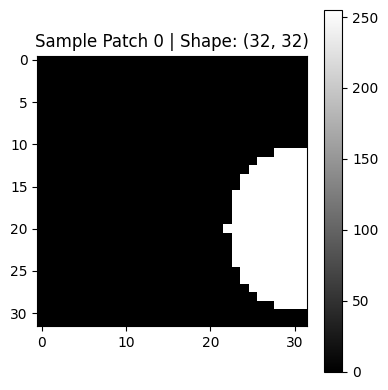

Sample patch stats: min=0, max=255, mean=36.86


In [20]:
# Cell 1: Import & Setup
import cv2
import numpy as np
import os
from pathlib import Path

# Setup directories
RAW_DIR         = "../data/tests/test2/00_raw"
PATCHES_DIR     = "../data/tests/test2/01_input_patches"
os.makedirs(PATCHES_DIR, exist_ok=True)

# Parameters
PATCH_SIZE = 32
STRIDE = 32  # Non-overlapping patches

print(f"Patch size: {PATCH_SIZE}x{PATCH_SIZE}")
print(f"Output directory: {PATCHES_DIR}")

# Cell 2: Load & Stack Images
# Load 2 images dari 00_raw
imgA = cv2.imread(os.path.join(RAW_DIR, "frame_1.png"), cv2.IMREAD_GRAYSCALE)
imgB = cv2.imread(os.path.join(RAW_DIR, "frame_2.png"), cv2.IMREAD_GRAYSCALE)

if imgA is None or imgB is None:
    raise FileNotFoundError("imgA.png atau imgB.png tidak ditemukan di 00_raw/")

print(f"imgA shape: {imgA.shape}")
print(f"imgB shape: {imgB.shape}")

# Stack jadi 1 image (concatenate vertikal atau horizontal)
# Opsi 1: Vertikal (stack atas-bawah)
stacked_img = np.vstack([imgA, imgB])

# Opsi 2: Horizontal (stack kiri-kanan) - uncomment jika mau
# stacked_img = np.hstack([imgA, imgB])

print(f"Stacked image shape: {stacked_img.shape}")

# Cell 3: Generate 32x32 Patches
patches = []
patch_positions = []

height, width = stacked_img.shape

# Crop ke ukuran kelipatan PATCH_SIZE agar seamless
height = (height // PATCH_SIZE) * PATCH_SIZE
width = (width // PATCH_SIZE) * PATCH_SIZE
stacked_img = stacked_img[:height, :width]

print(f"Cropped stacked image to: {stacked_img.shape}")

# Extract patches dengan stride
for y in range(0, height, STRIDE):
    for x in range(0, width, STRIDE):
        patch = stacked_img[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
        
        if patch.shape == (PATCH_SIZE, PATCH_SIZE):
            patches.append(patch)
            patch_positions.append((y, x))

patches = np.array(patches)
print(f"Total patches generated: {len(patches)}")
print(f"Patches shape: {patches.shape}")  # [N, 32, 32]

# Cell 4: Save Patches sebagai 32x32 PNG files
patch_counter = 0
for idx, patch in enumerate(patches):
    filename = f"patch_{idx:04d}.png"
    filepath = os.path.join(PATCHES_DIR, filename)
    
    # Normalize ke [0, 255] untuk save
    patch_uint8 = np.uint8(patch)
    cv2.imwrite(filepath, patch_uint8)
    patch_counter += 1

print(f"\n✅ Total {patch_counter} patches saved ke {PATCHES_DIR}/")
print(f"Format: patch_0000.png, patch_0001.png, ..., patch_{patch_counter-1:04d}.png")

# Cell 5: Visualisasi 1 patch sample
import matplotlib.pyplot as plt

sample_patch = patches[0]
plt.figure(figsize=(4, 4))
plt.imshow(sample_patch, cmap='gray')
plt.title(f"Sample Patch 0 | Shape: {sample_patch.shape}")
plt.colorbar()
plt.tight_layout()
plt.show()

print(f"Sample patch stats: min={sample_patch.min()}, max={sample_patch.max()}, mean={sample_patch.mean():.2f}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image

# --- CONFIG ---
SCALE = 1024.0      # Q6.10 Fixed Point
PATCHES_DIR = "../data/tests/test2/01_input_patches"  # Folder sumber patch (32x32)
VECTORS_DIR = "../data/tests/test2/02_vectors"  # Folder tujuan CSV
CSV_NAME    = "test2_input.csv"                 # Nama file CSV output

os.makedirs(VECTORS_DIR, exist_ok=True)

# 1. Ambil semua file patch & Urutkan
patch_files = sorted(glob.glob(os.path.join(PATCHES_DIR, "*.png")))

if not patch_files:
    print(f"❌ Tidak ada file .png di {PATCHES_DIR}")
else:
    print(f"📂 Ditemukan {len(patch_files)} patch. Memproses...")

    input_stream = []
    
    for i, p_file in enumerate(patch_files):
        # 2. Load Image & Convert to Grayscale
        # Pastikan resize ke 32x32 jika ukuran belum sesuai
        img = Image.open(p_file).convert('L').resize((32, 32))
        img_arr = np.array(img, dtype=np.float32)
        
        # Normalisasi: Image 0-255 -> Range -1.0 s/d 1.0 (Sesuai training GAN)
        # Rumus: (pixel / 127.5) - 1.0
        img_norm = (img_arr / 127.5) - 1.0
        
        # 3. Convert ke Fixed Point Q6.10
        img_fixed = np.clip(np.round(img_norm * SCALE), -32768, 32767).astype(int)
        
        # Flatten dan masukkan ke stream
        input_stream.extend(img_fixed.flatten())
        
        if i % 100 == 0: print(f"  > Processed patch {i}...")

    # 4. Simpan ke CSV
    output_path = os.path.join(VECTORS_DIR, CSV_NAME)
    np.savetxt(output_path, np.array(input_stream), fmt='%d')
    
    print(f"✅ Berhasil menyimpan Input CSV: {output_path}")
    print(f"📊 Total Data Points: {len(input_stream)}")

❌ Tidak ada file .png di ../data/tests/test2/01_patches
